# Homogeneous Representations of Spectroscopic Data Cubes 
# Part 2: APPlications
## Astronomy and Computing Journal, 2017
### Mauricio Araya (1), Diego Mardones (2), Marcelo Mendoza (1) and Mauricio Solar (1)

(1) Universidad Técnica Federico Santa María <br>
(2) Universidad de Chile

# 1. Introduction

This notebook contains the code for replicating the experiments presented in the paper "Homogeneous Representations of Spectroscopic Data Cubes". First, you need to download and install the development version of the library `acalib` from github. (part 2)

> git clone acalib

> python setup.py

(The pip version is not useful).

### Imports and Initialization

In [1]:
#matplotlib qt
%matplotlib inline

import acalib

### Downloading Data
Our data set is composed by a few spectroscopic cubes from the [ALMA Science Verification Dataset](https://almascience.nrao.edu/alma-data/science-verification). The following code download, uncompress and rename the files for its use.
Please note that this code does not download de data again if it is found (was downloaded for example en part 1)

In [2]:
import os
import urllib.request
import tarfile
from shutil import copyfile

DOWNLOADS_DIR = 'data/'

# Data from ALMA science verification 

# URLs of the tarballs
urls  = ['https://almascience.nrao.edu/almadata/sciver/OrionKLBand6/OrionKL_Band6_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz',
         'https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz',
         #'https://bulk.cv.nrao.edu/almadata/sciver/AntennaeBand7/Antennae_Band7_ReferenceImages.tgz',
         'https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz']

# Fits names and their "fantasy" names 
flist  = [('Orion.methanol.cbc.contsub.image.fits',          'Orion-CH3OH'),
          ('TWHydra_CO3_2line.image.fits',                   'TWHydra-CO3_2'),
          ('M100line.image.fits',                            'M100-CO1_0'),
          #('Antennae_North.CO3_2Line.Clean.pcal1.image.fits','AntennaeN-CO3_'),
          ('I16293_220GHzcorrected.ms.selfcube.image.fits',  'IRAS16293-2422-HCOCH')]

fits_map=dict(zip(urls, flist))

for url,ffile in fits_map.items():
    # Split on the rightmost / and take everything on the right side of that
    name = url.rsplit('/', 1)[-1]
    # Combine the name and the downloads directory to get the local filename
    filename = os.path.join(DOWNLOADS_DIR, name)
    if not os.path.isfile(filename):
        print("Downloading "+str(url))
        urllib.request.urlretrieve(url, filename)
    else:
        print("File found, skipping download of "+str(url))
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    #print(sdir)
    if not os.path.isdir(sdir):
        print("Uncompressing "+str(filename))
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()
    else:
        print("Directory "+str(sdir)+ " found, not uncompressing")
    copyfile(sdir+"/"+ffile[0], DOWNLOADS_DIR+"/"+ffile[0])
    

File found, skipping download of https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz
Directory data/TWHYA_BAND7_ReferenceImages found, not uncompressing
File found, skipping download of https://almascience.nrao.edu/almadata/sciver/IRAS16293Band6/IRAS16293_Band6_ReferenceImages.tgz
Directory data/IRAS16293_Band6_ReferenceImages found, not uncompressing
File found, skipping download of https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz
Directory data/M100_Band3_ReferenceImages found, not uncompressing
File found, skipping download of https://almascience.nrao.edu/almadata/sciver/OrionKLBand6/OrionKL_Band6_ReferenceImages.tgz
Directory data/OrionKL_Band6_ReferenceImages found, not uncompressing


### Load Data from part 1

In [3]:

from astropy.nddata import NDData
from astropy.io import ascii,fits
ghr_table=ascii.read("GHR-Summary.dat")
phr_table=ascii.read("PHR-Summary.dat")
snr_table=ascii.read("SNR-Summary.dat")
summary=ascii.read("Data-Summary.dat")
rep_list=[]
syn_list=[]
resi_list=[]
for i in range(len(flist)):
    ffile=flist[i]
    name=ffile[1]
    rep_list.append(ascii.read("REP-"+name+".dat"))
    cube=acalib.load("SYN-"+name+".fits")    
    syn_list.append(cube.data)
    cube=acalib.load("RES-"+name+".fits")    
    resi_list.append(cube.data)

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]


In [4]:
ghr_table

Name,RMS,SNR,Pts,Pts/Bound,Pts/Phr,Pts/Valid
str20,float64,float64,int64,float64,float64,float64
Orion-CH3OH,2.60771895779e-06,1.01,7026,0.104892286102,0.12554499321,0.0171365853659
TWHydra-CO3_2,8.99479067679e-07,1.118,1550,0.0599613152805,0.0651369978148,0.00131355932203
M100-CO1_0,9.18094227979e-08,1.592,12098,0.116767045016,0.118735891648,0.00145364136079
IRAS16293-2422-HCOCH,5.8952157086e-08,1.41,34511,0.0991279520661,0.105202350904,0.00276328516341


In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['axes.formatter.limits']=(-5,5)
def fmt(x, pos):
    return '{:.1e}'.format(x)
import numpy as np

# 5. Applications of the representation
# 5.1 Orion-KL
Load Orion-KL example, and compute $\sigma$, $\Delta$ and the mould Gaussian. Also arange the GHR as a `numpy.ndarray` and computes the moment0 of the cube (for visualization purposes)

In [6]:
from acalib.core import synthesize_bubbles, precision_from_delta, create_mould
ffile        = flist[0]
orig         = acalib.load(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = acalib.standarize(orig)
orig2D       = acalib.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[0]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T


INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


### Vertical Flux Decomposition function

In [7]:
def vertical_flux_decomposition(rep,m,shape,mould,noise,delta):
    n_rep=len(rep)/m
    img_list=[]
    vmax=0
    for i in range(m):
        synNew=np.zeros(shape)
        ini=n_rep*i
        end=n_rep*(i+1) - 1
        p_rep=rep[ini:end]
        synthesize_bubbles(synNew,p_rep,mould,noise,delta)
        img=synNew.sum(axis=(0))
        vmax=max(vmax,img.max())
        img_list.append(img)
    return img_list,vmax

### Grid Visualization function

In [8]:

def show_decomposition_grid(img_list,side,vmax):
    cmap="jet"
    origin="lower"

    plt.figure()
    gs = gridspec.GridSpec(side, side,wspace=0.0, hspace=0.0)
    for i in range(side*side):
        ax  = plt.subplot(gs[i])
        ax.imshow(img_list[i],origin=origin,vmax=vmax,vmin=0,cmap=cmap)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

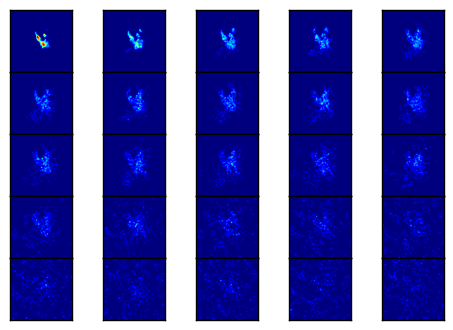

In [9]:
side=5
img_list,vmax=vertical_flux_decomposition(rep,side*side,orig.data.shape,mould,noise,delta)
show_decomposition_grid(img_list,side,vmax)

Threshold representation up to the 15th level and print it

In [16]:
import matplotlib.pyplot as plt

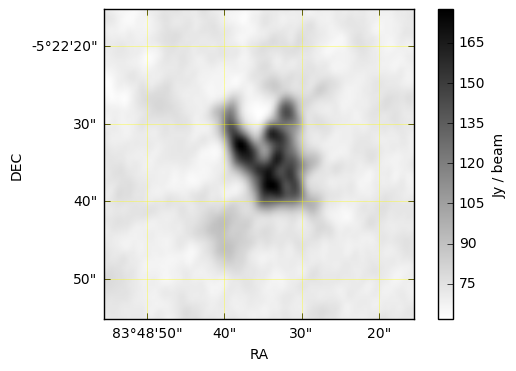

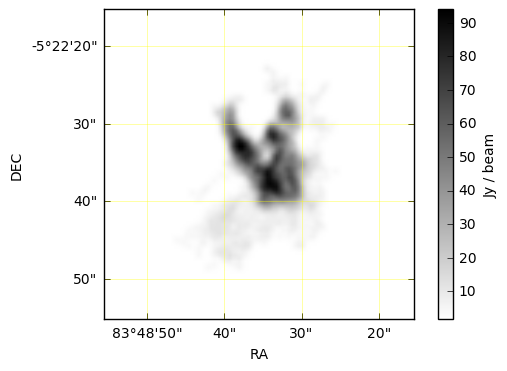

8430


In [17]:

limit  = 10*int(rep.shape[0]/(side*side))
th_rep = rep[0:limit]
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,th_rep,mould,noise,delta)
#print(noise)
img    = synNew.sum(axis=(0))
plt.figure()
acalib.visualize_image(orig2D.data*ym - yf,wcs=orig2D.wcs,unit=orig2D.unit,cmap=plt.cm.gray_r)
plt.figure()
acalib.visualize_image(img*ym-yf,wcs=orig2D.wcs,unit=orig2D.unit,cmap=plt.cm.gray_r)
print(th_rep.size)

In [18]:
def show_clusters(labels,sol,start,stop,shape,template,mould,noise,delta):
    if start is None:
        start=0
    nclus=labels.max()+1
    if stop is None:
        stop=nclus+1
    print("Number of Clusters = "+str(nclus))
    fig=plt.figure(figsize=(5,4))
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[shape[2]/shape[0], 1], height_ratios=[shape[1]/shape[0],1])
    
    tempXY=template.sum(axis=(0))
    #nax=fig.add_subplot(2,3,1)
    nax=plt.subplot(gs[0])
    nax.imshow(tempXY, origin='lower',cmap=plt.cm.gray_r)
    nax.get_xaxis().set_visible(False)
    nax.get_yaxis().set_visible(False)
 
    tempXZ=template.sum(axis=(1))
    #nax2=fig.add_subplot(2,3,4)
    nax2=plt.subplot(gs[2])
    nax2.imshow(tempXZ, origin='lower',cmap=plt.cm.gray_r)
    nax2.get_xaxis().set_visible(False)
    nax2.get_yaxis().set_visible(False)
   
    tempYZ=template.sum(axis=(2)).T
    #nax3=fig.add_subplot(2,3,2)
    nax3=plt.subplot(gs[1])
    nax3.imshow(tempYZ, origin='lower',cmap=plt.cm.gray_r)
    nax3.get_xaxis().set_visible(False)
    nax3.get_yaxis().set_visible(False)
    
    mmask=(labels>-1)
    labels=labels[mmask]
    sol=sol[mmask]
    bco=np.bincount(labels)
    bco=bco.argsort()[::-1][start:stop]
    color=plt.cm.rainbow(np.linspace(0,1,stop-start))
    
    i=0
    for b in bco:
        imask=(labels==b)
        npos  = sol[imask]
        newSyn=np.zeros(shape)
        newSyn=synthesize_bubbles(newSyn,npos,mould,noise,delta)
        nax.contour(newSyn.sum(axis=(0)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax2.contour(newSyn.sum(axis=(1)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax3.contour(newSyn.sum(axis=(2)).T,levels=[0.0],alpha=1.0,colors=[color[i]])
        i+=1
    plt.tight_layout()
    plt.show()
    plt.figure()
    
    #nax4=fig.add_subplot(1,3,3)
    nax4=plt.subplot(111)
    i=0
    for b in bco:
        imask=(labels==b)
        npos  = sol[imask]
        newSyn=np.zeros(shape)
        newSyn=synthesize_bubbles(newSyn,npos,mould,noise,delta)
        nax.contour(newSyn.sum(axis=(0)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax2.contour(newSyn.sum(axis=(1)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax3.contour(newSyn.sum(axis=(2)).T,levels=[0.0],alpha=1.0,colors=[color[i]])
        nax4.plot(newSyn.sum(axis=(1,2)),color=color[i])
        i+=1
    plt.tight_layout()
    plt.show()
    return(bco)

In [19]:
from sklearn.cluster import *
#clust=AffinityPropagation(damping=0.878).fit(th_rep)
#clust=MeanShift(bandwidth=).fit(th_rep)
clust=SpectralClustering(n_clusters=5,gamma=0.5).fit(th_rep)

Number of Clusters = 5


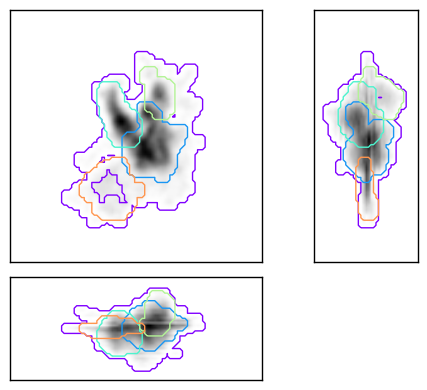

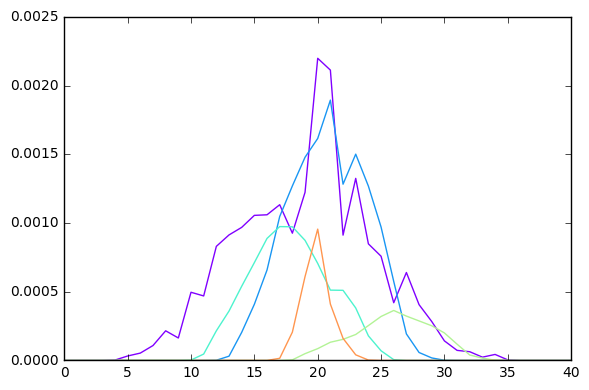

array([3, 0, 1, 2, 4])

In [20]:
show_clusters(clust.labels_,th_rep,None,None,orig.data.shape,synNew,mould,noise,delta)

## 5.2. TWHydra


In [23]:
ffile        = flist[1]
orig         = acalib.load(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = acalib.standarize(orig)
orig2D       = acalib.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[1]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T

INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [24]:
clust=MeanShift().fit(rep)
#imask=(clust.labels_==0)
#rep_fp=rep[imask]
#clust2=MeanShift().fit(rep_fp)

Number of Clusters = 19


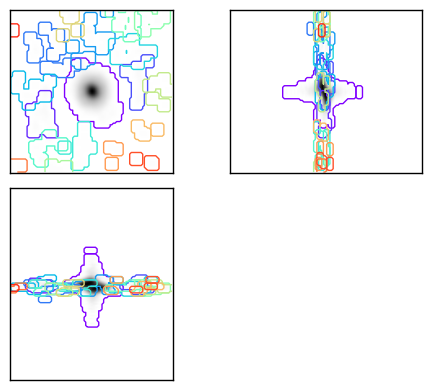

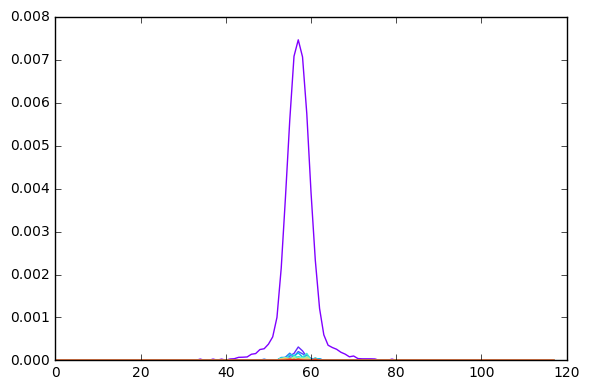

In [25]:
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,rep,mould,noise,delta)
order=show_clusters(clust.labels_,rep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [26]:
newRep=np.ndarray((0,3))
imask=(clust.labels_==order[0])
newRep=np.vstack((newRep,rep[imask]))

In [27]:
from mpl_toolkits.mplot3d import Axes3D

def show_manifold(sm):
    cbook=sm.codebook.matrix
    fig=plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cbook[:,0],cbook[:,1], cbook[:,2])#, c=c, marker=m)
    for cb,dm_elm in zip(cbook,sm._distance_matrix):
        #print(cb)
        conn=(dm_elm==1).nonzero()
        #print(conn[0])
        for idx in conn[0]:
            #print(idx)
            ot=cbook[idx]
            #print(ot)
            ax.plot([cb[0],ot[0]],[cb[1],ot[1]],[cb[2],ot[2]],color = 'g')
    plt.show()

In [30]:

from sompy.sompy import SOMFactory
sm = SOMFactory().build(newRep, normalization = 'var', initialization='pca')
sm.train(n_job=1, verbose=False, train_rough_len=30, train_finetune_len=30)


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


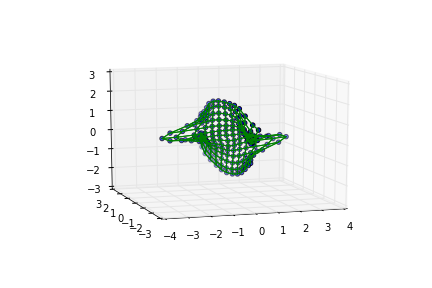

In [31]:
%matplotlib notebook
show_manifold(sm)

## 5.3. M100


In [33]:
%matplotlin inline
ffile        = flist[2]
orig         = acalib.load(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = acalib.standarize(orig)
orig2D       = acalib.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[2]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T

Line magic function `%matplotlin` not found.
Processing PrimaryHDU Object 0
Removing superfluous dimension STOKES (kept in the metadata)


INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
overwriting Masked Objects's current mask with specified mask.


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


<IPython.core.display.Javascript object>


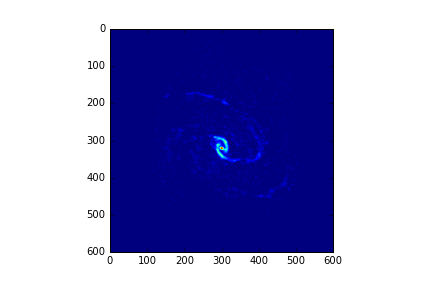

In [34]:
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,rep,mould,noise,delta)
plt.figure()
plt.imshow(synNew.sum(axis=(0)))

Number of Clusters = 87


<IPython.core.display.Javascript object>


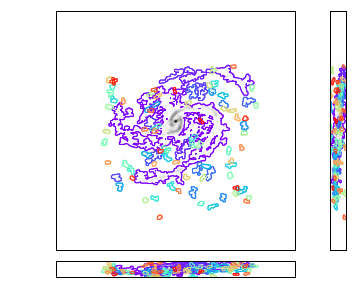

<IPython.core.display.Javascript object>


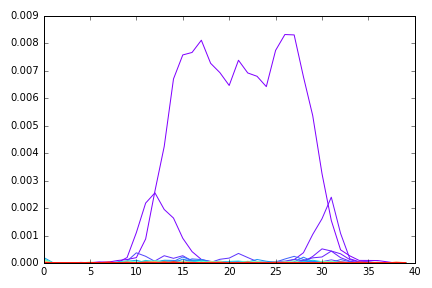

In [35]:
clust=DBSCAN(eps=7.0).fit(rep)
order=show_clusters(clust.labels_,rep,None,None,orig.data.shape,synNew,mould,noise,delta)

Number of Clusters = 87


<IPython.core.display.Javascript object>


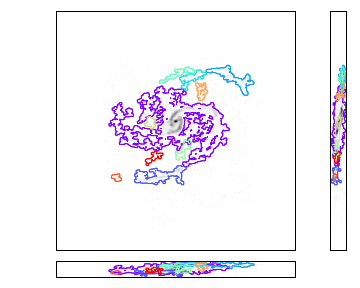

<IPython.core.display.Javascript object>


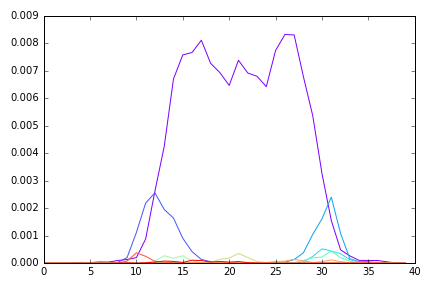

In [36]:
ccut=10
order=show_clusters(clust.labels_,rep,None,ccut,orig.data.shape,synNew,mould,noise,delta)
newRep=np.ndarray((0,3))
for i in range(ccut):
    imask=(clust.labels_==order[i])
    #print(newRep.shape,rep[imask].shape)
    newRep=np.vstack((newRep,rep[imask]))

Number of Clusters = 50


<IPython.core.display.Javascript object>


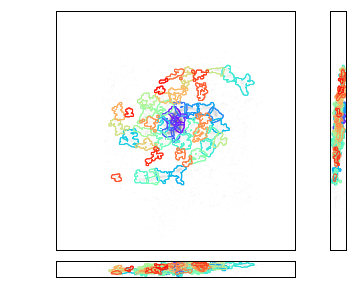

<IPython.core.display.Javascript object>


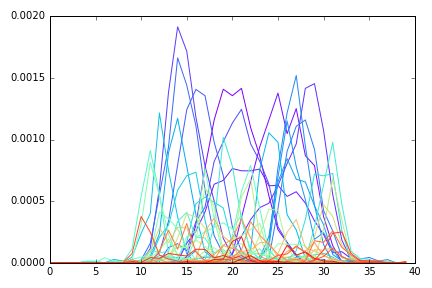

array([ 6,  0, 39, 28, 25, 48, 30, 10, 29, 21, 12, 18,  8, 16, 27,  4, 49,
       15, 13,  3, 23, 38, 47, 35, 42,  1, 26, 22, 31, 20,  9,  2, 41, 19,
       32, 46, 40,  7, 45, 37, 44,  5, 11, 36, 33, 17, 14, 24, 43, 34])

In [37]:
clust=KMeans(n_clusters=50).fit(newRep)
show_clusters(clust.labels_,newRep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [38]:
def row_col_from_condensed_index(d,i):
    b = 1 -2*d 
    x = np.floor((-b - np.sqrt(b**2 - 8*i))/2)
    y = i + x*(b + x + 2)/2 + 1
    return (x,y)  

<IPython.core.display.Javascript object>


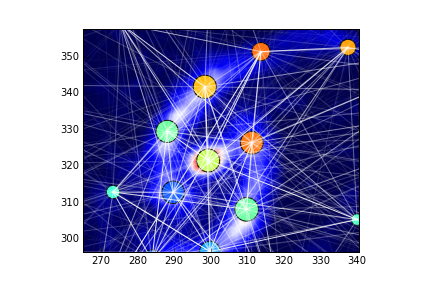

In [39]:
ss=np.bincount(clust.labels_)
ms=ss.max()
from scipy.spatial.distance import pdist,squareform
pps=clust.cluster_centers_
dds=pdist(pps)
dm=dds.max()
fig=plt.figure()
ax = fig.add_subplot(111)
ax.imshow(synNew.sum(axis=(0)),origin='lower',cmap='seismic')
ax.scatter(pps[:,2],pps[:,1],c=pps[:,0],s=ss)#, c=c, marker=m)
k=0
for con in dds:
    (i,j)=row_col_from_condensed_index(pps.shape[0],k)
    if i==j:
        continue
    cb=pps[i]
    ot=pps[j]
    d=con/dm
    mi=ss[i]/ms
    mj=ss[j]/ms
    metr=mi*mj/(d*d)*0.05
    ax.plot([cb[2],ot[2]],[cb[1],ot[1]], alpha = metr,color="w")
    k+=1

## 5.4. IRAS

In [43]:
ffile        = flist[3]
orig         = acalib.load(DOWNLOADS_DIR+ffile[0])
target       = ffile[1]
(orig,ym,yf) = acalib.standarize(orig)
orig2D       = acalib.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[3]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T

Processing PrimaryHDU Object 0
Removing superfluous dimension STOKES (kept in the metadata)


INFO: Processing PrimaryHDU Object 0 [acalib.io.fits]
INFO: Removing superfluous dimension STOKES (kept in the metadata) [acalib.io.fits]


/home/mauricio/anaconda3/envs/astro3.5/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
overwriting Masked Objects's current mask with specified mask.


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [44]:
def show_clusters2(labels,sol,start,stop,shape,template,mould,noise,delta):
    if start is None:
        start=0
    nclus=labels.max()+1
    if stop is None:
        stop=nclus+1
    print("Number of Clusters = "+str(nclus))
    fig=plt.figure(figsize=(5,4))
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[shape[2]/shape[0], 1], height_ratios=[shape[1]/shape[0],1])
    
    tempXY=template.sum(axis=(0))
    #nax=fig.add_subplot(2,3,1)
    nax=plt.subplot(gs[0])
    nax.imshow(tempXY, origin='lower',cmap=plt.cm.gray)
    nax.get_xaxis().set_visible(False)
    nax.get_yaxis().set_visible(False)
 
    tempXZ=template.sum(axis=(1))
    #nax2=fig.add_subplot(2,3,4)
    nax2=plt.subplot(gs[2])
    nax2.imshow(tempXZ, origin='lower',cmap=plt.cm.gray)
    nax2.get_xaxis().set_visible(False)
    nax2.get_yaxis().set_visible(False)
   
    tempYZ=template.sum(axis=(2)).T
    #nax3=fig.add_subplot(2,3,2)
    nax3=plt.subplot(gs[1])
    nax3.imshow(tempYZ, origin='lower',cmap=plt.cm.gray)
    nax3.get_xaxis().set_visible(False)
    nax3.get_yaxis().set_visible(False)
    
    mmask=(labels>-1)
    labels=labels[mmask]
    sol=sol[mmask]
    bco=np.bincount(labels)
    bco=bco.argsort()[::-1][start:stop]
    color=plt.cm.rainbow(np.linspace(0,1,stop-start))
    
    nax4=plt.subplot(gs[3])
    
    i=0
    for b in bco:
        imask=(labels==b)
        npos  = sol[imask]
        newSyn=np.zeros(shape)
        newSyn=synthesize_bubbles(newSyn,npos,mould,noise,delta)
        nax.contour(newSyn.sum(axis=(0)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax2.contour(newSyn.sum(axis=(1)),levels=[0.0],alpha=1.0,colors=[color[i]])
        nax3.contour(newSyn.sum(axis=(2)).T,levels=[0.0],alpha=1.0,colors=[color[i]])
        nax4.plot(newSyn.sum(axis=(1,2)),color=color[i])
        i+=1
    plt.tight_layout()
    plt.show()
    return(bco)

Number of Clusters = 69


<IPython.core.display.Javascript object>


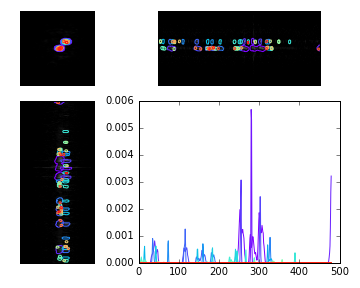

In [45]:
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,rep,mould,noise,delta)
clust=DBSCAN(eps=1.5).fit(rep)
order=show_clusters2(clust.labels_,rep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [46]:
db_rep=rep[clust.labels_!=-1]
print(rep.shape)
print(db_rep.shape)

(34511, 3)
(8596, 3)


Number of Clusters = 100


<IPython.core.display.Javascript object>


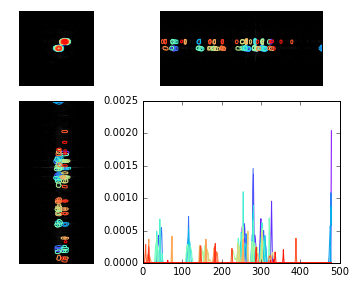

In [47]:
from sklearn.mixture import GaussianMixture
from astropy import units as u
ncomp=100
model=GaussianMixture(n_components=ncomp).fit(db_rep)
labels=model.predict(db_rep)
order=show_clusters2(labels,db_rep,None,None,orig.data.shape,synNew,mould,noise,delta)


In [48]:
def compute_gclumps_parameters(rep,P,cid):
    fwhm_c=np.sqrt(8*np.log(2))
    mu=rep.mean(axis=(0))
    vec=(mu - rep)
    c=rep.size
    Sigma=np.linalg.inv(P)+np.dot(vec.T,vec)/c
    A=np.linalg.inv(Sigma)
    dv=np.sqrt(1./A[0,0])
    ga=-A[2,0]/A[0,0]
    gd=-A[1,0]/A[0,0]
    b0=A[1,1]-(gd*gd)/(dv*dv)
    b1=A[1,2]-(ga*gd)/(dv*dv)
    b2=A[2,2]-(ga*ga)/(dv*dv)
    B=np.linalg.inv(np.array([[b0,b1],[b1,b2]]))
    (U,S,V)=np.linalg.svd(B)
    de=np.sqrt(S)
    return(cid,c,mu[2],mu[1],mu[0],fwhm_c*de[1],fwhm_c*de[0],(np.arcsin(-U[0,0])*u.rad).to("deg").value,fwhm_c*dv,gd,ga)

In [50]:
from astropy.table import Table
gclu=Table(names=('CLUST ID',
                  'N', 
                  'RA',
                  'DEC',
                  'FREQ',
                  'SEMIAXIS 1',
                  'SEMIAXIS 2',
                  'ANGLE',
                  'LINE FWHM',
                  'GRAD RA/FREQ',
                  'GRAD DEC/FREQ'))

for i in order:
    imask=(labels==i)
    rep_gm=db_rep[imask]
    gclu.add_row(vals=compute_gclumps_parameters(rep_gm,P,i))
gclu

CLUST ID,N,RA,DEC,FREQ,SEMIAXIS 1,SEMIAXIS 2,ANGLE,LINE FWHM,GRAD RA/FREQ,GRAD DEC/FREQ
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
54.0,513.0,116.228070175,109.380116959,478.830409357,3.6708900828,4.2903834276,20.3596693967,1.20890972225,-0.0105993785913,0.00791203207417
71.0,498.0,117.951807229,108.626506024,253.686746988,2.9145903221,3.80270361734,73.1013634023,2.32295539953,0.0256826735688,-0.178592050241
0.0,477.0,132.716981132,126.314465409,280.566037736,3.05017863179,3.55130596742,66.7674816635,1.28379757032,0.0289521055704,-0.00416151740209
98.0,471.0,139.191082803,129.687898089,280.573248408,3.02590548086,3.61903673433,-14.5417020166,1.27315451519,0.016993538789,-0.067419758448
70.0,471.0,115.050955414,109.828025478,299.401273885,3.01385842581,3.64844716349,77.3692562104,2.20053696698,0.0651058940603,0.00859454225577
29.0,462.0,118.175324675,107.383116883,284.175324675,3.05019358037,3.84555551451,75.5607160619,2.77840395254,-0.160712506594,0.00812956586456
7.0,459.0,135.849673203,127.862745098,326.738562092,3.23322604129,5.73841509468,-3.63903186066,1.77289060443,0.058761985192,-0.00659907468384
3.0,447.0,114.979865772,107.590604027,39.9865771812,3.07988496875,3.79807503102,20.2360192325,3.0500128212,-0.0584253499433,0.0801736195374
39.0,447.0,113.44966443,106.973154362,258.375838926,3.01923203068,3.39013138773,50.2649580652,3.20513566759,-0.185831223358,0.104919333507


In [51]:
ttab=gclu[gclu['LINE FWHM']>3]
# Generating the latex table for the paper
from astropy.io import ascii
ascii.write(ttab,format='latex')

\begin{table}
\begin{tabular}{ccccccccccc}
CLUST ID & N & RA & DEC & FREQ & SEMIAXIS 1 & SEMIAXIS 2 & ANGLE & LINE FWHM & GRAD RA/FREQ & GRAD DEC/FREQ \\
3.0 & 447.0 & 114.979865772 & 107.590604027 & 39.9865771812 & 3.07988496875 & 3.79807503102 & 20.2360192325 & 3.0500128212 & -0.0584253499433 & 0.0801736195374 \\
39.0 & 447.0 & 113.44966443 & 106.973154362 & 258.375838926 & 3.01923203068 & 3.39013138773 & 50.2649580652 & 3.20513566759 & -0.185831223358 & 0.104919333507 \\
43.0 & 423.0 & 121.163120567 & 108.411347518 & 39.865248227 & 3.04866853261 & 3.60108607475 & 29.6449563085 & 3.2850795756 & -0.152705832166 & -0.0959047586354 \\
56.0 & 327.0 & 125.091743119 & 107.293577982 & 308.229357798 & 2.879473102 & 3.2498168606 & 77.6044760064 & 3.18891940371 & -0.0569774101458 & 0.0995846035968 \\
1.0 & 297.0 & 119.808080808 & 108.878787879 & 114.393939394 & 2.95419353269 & 3.31450679868 & -29.3614160499 & 3.20028800171 & 0.0521939501631 & 0.0157092708989 \\
18.0 & 288.0 & 135.71875 & 127.6

1221
(1221, 3)
Number of Clusters = 14


<IPython.core.display.Javascript object>


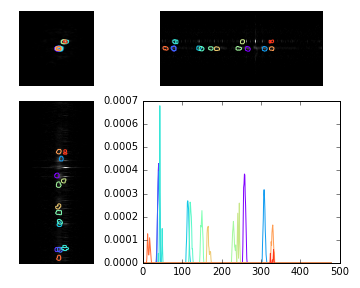

In [52]:
elms=gclu[gclu['LINE FWHM']>3]['CLUST ID']
newRep=np.ndarray((0,3))
newLab=[]
count=0
for j in elms:
    imask=(labels==j)
    current=db_rep[imask]
    newRep=np.vstack((newRep,current))
    newLab.extend([count]*int(current.shape[0]))
    count+=1
print(len(newLab))
print(newRep.shape)
order=show_clusters2(np.array(newLab),newRep,None,None,orig.data.shape,synNew,mould,noise,delta)

## 5.X. Antennae (REMOVED FROM PAPER)

In [40]:
ffile        = flist[3]
hdulist      = fits.open(DOWNLOADS_DIR+ffile[0])
orig         = aca.HDU_to_NDData(hdulist[0])
target       = ffile[1]
(orig,ym,yf) = aca.standarize(orig)
orig2D       = aca.moment0(orig)
noise        = snr_table['RMS'][0]
spa          = np.ceil((np.abs(orig.meta['BMIN']/orig.meta['CDELT1']) - 1)/2.0)
delta        = [1,spa,spa]
P            = precision_from_delta(delta,0.1)
mould        = create_mould(P,delta)
rep_t        = rep_list[3]
rep          = np.array([rep_t[c] for c in rep_t.columns])
rep          = rep.T

NameError: name 'aca' is not defined

In [ ]:
synNew = np.zeros(orig.data.shape)
synthesize_bubbles(synNew,rep,mould,noise,delta)
plt.figure()
plt.imshow(synNew.sum(axis=(0)))

In [ ]:
clust=DBSCAN(eps=3.0).fit(rep)
order=show_clusters(clust.labels_,rep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [ ]:
ccut=10
order=show_clusters(clust.labels_,rep,None,ccut,orig.data.shape,synNew,mould,noise,delta)
newRep=np.ndarray((0,3))
for i in range(ccut):
    imask=(clust.labels_==order[i])
    #print(newRep.shape,rep[imask].shape)
    newRep=np.vstack((newRep,rep[imask]))

In [ ]:
clust=KMeans(n_clusters=50).fit(newRep)
show_clusters(clust.labels_,newRep,None,None,orig.data.shape,synNew,mould,noise,delta)

In [ ]:
def row_col_from_condensed_index(d,i):
    b = 1 -2*d 
    x = np.floor((-b - np.sqrt(b**2 - 8*i))/2)
    y = i + x*(b + x + 2)/2 + 1
    return (x,y)  

In [ ]:
ss=np.bincount(clust.labels_)
ms=ss.max()
from scipy.spatial.distance import pdist,squareform
pps=clust.cluster_centers_
dds=pdist(pps)
dm=dds.max()
fig=plt.figure()
ax = fig.add_subplot(111)
ax.imshow(synNew.sum(axis=(0)),origin='lower',cmap='seismic')
k=0
for con in dds:
    (i,j)=row_col_from_condensed_index(pps.shape[0],k)
    if i==j:
        continue
    cb=pps[i]
    ot=pps[j]
    d=con/dm
    mi=ss[i]/ms
    mj=ss[j]/ms
    metr=mi*mj/(d*d)*0.02
    ax.plot([cb[2],ot[2]],[cb[1],ot[1]], alpha = metr,color="w")
    k+=1
ax.scatter(pps[:,2],pps[:,1],c=pps[:,0],s=ss/2.0)#, c=c, marker=m)